In [3]:
import torch
import torch.nn as nn 
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
import numpy as np
from torchinfo import summary
from PIL import Image
import torch.nn.functional as F
from torchvision.datasets import FakeData # Test
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import math
import random

Size of data_coins 5000 : Size of labels_coins 5000
Size of data_others 5000 : Size of labels_others 5000


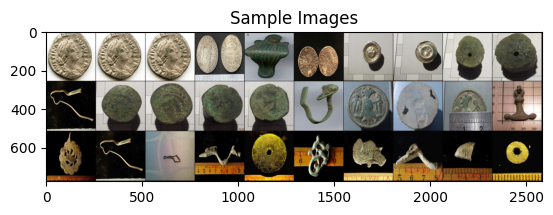

In [4]:
# Load data from external source
import os
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# Docs:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html?highlight=dataloader

# 256x256 images
path_to_coins = "/run/media/magnusjsc/T7/Classification-and-3D-reconstruction-of-archaeological-artifacts_DATA/resized_images_coin_256x256/"
path_to_others = "/run/media/magnusjsc/T7/Classification-and-3D-reconstruction-of-archaeological-artifacts_DATA/resized_images_others_256x256/"

'''
path_to_coins = "/mnt/c/Users/bucha/Pictures/resized_images_coin_256x256"
path_to_others = "/mnt/c/Users/bucha/Pictures/resized_images_others_256x256"
'''

def load_data_from_directory_with_limit(directory_path, label, limit = 10000):
    data = []
    labels = []
    count = 0

    for filename in os.listdir(directory_path):
        if filename.endswith(".jpg"): 
            image_path = os.path.join(directory_path, filename)
            image = read_image(image_path)

            # Check if the image is RGB
            if image.shape[0] == 3:
                data.append(image)
                labels.append(label)
                count += 1

            if count >= limit:
                break

    return data, labels # Tuple

# Load data call
data_coins, labels_coins = load_data_from_directory_with_limit(path_to_coins, label = 1, limit = 5000)
data_others, labels_others = load_data_from_directory_with_limit(path_to_others, label = 0, limit = 5000)

print(f'Size of data_coins {len(data_coins)} : Size of labels_coins {len(labels_coins)}')
print(f'Size of data_others {len(data_others)} : Size of labels_others {len(labels_others)}')

def imshow_grid(images, num_images = 30):
    grid = torchvision.utils.make_grid(images[:num_images], nrow = 10)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title('Sample Images')
    plt.axis('on')
    plt.show()

num_images_to_display_per_category = 15
data_to_display = data_coins[:num_images_to_display_per_category] + data_others[:num_images_to_display_per_category]
imshow_grid(data_to_display, num_images = num_images_to_display_per_category * 2)

In [5]:
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchvision import transforms
from torchvision.io import read_image
import torch
import torchvision
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

class customDataset(Dataset):
    def __init__(self, tensors, transform = None):
        # Check the sizes of data and labels match
        assert all(tensors[0].size(0) == t.size(0) for t in tensors), "Size mismatch between tensors"

        # Assign input
        self.tensors = tensors
        self.transform = transform

    # What to do when we want an item from the dataset
    def __getitem__(self, index):
        # Return the transformed version of x if there are transforms
        if self.transform:
            x = self.transform(self.tensors[0][index])
        else: 
            x = self.tensors[0][index]

        # And return the label too
        y = self.tensors[1][index].view(1) # Convert y to a single-element tensor

        return x,y # Return the data as a tuple (data,label)

    def __len__(self):
        return self.tensors[0].size(0)


# Create a list of  transforms
imgTrans = transforms.Compose(
    [
        transforms.ToPILImage(), # PIL = library for images - Works for several transformations. To PIL image type
        transforms.RandomVerticalFlip(p = .5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor() # Transform the image to PyTorch tensor and normalizes the data [0;1] - Last 
    ]
)

# To Torch tensors
coin_dataT = torch.stack(data_coins)
coin_labelsT = torch.tensor(labels_coins)
other_dataT = torch.stack(data_others)
other_labelsT = torch.tensor(labels_others)

# For the Coin dataset
coin_data_transformed_defined = customDataset(tensors = (coin_dataT, coin_labelsT), transform = imgTrans)
# For the Other dataset
other_data_transformed_defined = customDataset(tensors = (other_dataT, other_labelsT), transform = imgTrans)
# Combine these two above datasets
combined_dataset_transformed_defined = ConcatDataset([coin_data_transformed_defined, other_data_transformed_defined])

# Split the data for training, validation, and testing
training = 0.7
validation = 0.15
testing = 0.15

total_size = len(combined_dataset_transformed_defined)
train_size = int(training * total_size)
val_size = int(validation * total_size)
test_size = total_size - train_size - val_size

# Randomly split the full dataset into training, validation and testing sets
train_set, val_set, test_set = random_split(combined_dataset_transformed_defined, [train_size, val_size, test_size])

# Hyperparameter - Batch size - GPU may be overloaded with memory allocations if too high
BATCH_SIZE = 5
# Create data loaders for each set
coin_loader = DataLoader(coin_data_transformed_defined, batch_size = 20, shuffle = False) # For visuals -> below cell
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True) # Shuffle the training set
val_loader = DataLoader(val_set, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, shuffle = False)

print(f'Total number of elements in train_loader: {len(train_loader) * BATCH_SIZE} : Each batch size {len(train_loader)}')
print(f'Total number of elements in val_loader: {len(val_loader) * BATCH_SIZE} : Each batch size {len(val_loader)}')
print(f'Total number of elements in test_loader: {len(test_loader) * BATCH_SIZE} : Each batch size {len(test_loader)}')

Total number of elements in train_loader: 7000 : Each batch size 1400
Total number of elements in val_loader: 1500 : Each batch size 300
Total number of elements in test_loader: 1500 : Each batch size 300


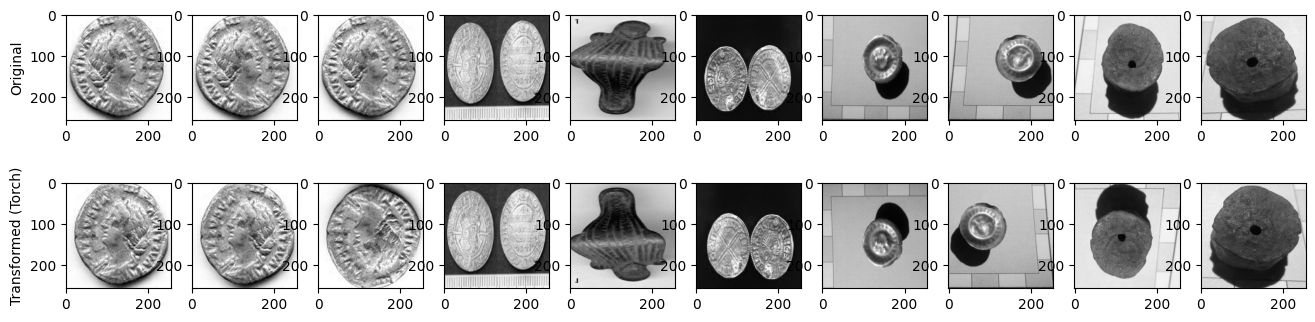

In [4]:
# Get a mini-batch from the train_loader and show differences before and after transformation
# Get the first 10 images from the train_loader
X, y = next(iter(coin_loader))

fig, axs = plt.subplots(2, 10, figsize = (16, 4))

# Loop over the first 10 images
for i in range(10):
    # Original images
    axs[0, i].imshow(coin_dataT[i, 0, :, :].detach().numpy(), cmap = 'gray')
    # Transformed images
    axs[1, i].imshow(X[i, 0, :, :].detach().numpy(), cmap = 'gray')

# Set labels
axs[0, 0].set_ylabel('Original')
axs[1, 0].set_ylabel('Transformed (Torch)')

plt.show()

In [6]:
# Pytorch VisionTransformer source code: https://github.com/pytorch/vision/blob/main/torchvision/models/vision_transformer.py
# NEED TO CHECK: https://learnopencv.com/the-future-of-image-recognition-is-here-pytorch-vision-transformer/

toggle_print = False # Change to 'True' to print information of the model

# Using the convolution kernel for ease of implementation and patch embeddings - First step
# Using a Conv2d layer for linear projection it becomes a hybrid model
class PatchEmbeddings(nn.Module):
    def __init__(
        self,
        d_model: int, 
        patch_size: int, 
        in_channels: int 
    ):
        super().__init__()

        # Sliding window approach - Size(Kernel)=Size(Stride)
        self.conv = nn.Conv2d(
            in_channels = in_channels, # 3 channel: RGB
            out_channels = d_model, 
            kernel_size = patch_size, 
            stride = patch_size,
            bias = True
        )
        # Output is a set of n feature maps which is a flattened representation of the image patches and can be treated as vectors.

    def forward(self, x: torch.Tensor):
        x = self.conv(x)
        bs, c, h, w = x.shape
        print(f'Shape of x after convolution: {x.shape}') if toggle_print else None
        x = x.permute(2, 3, 0, 1)
        x = x.view(h * w, bs ,c)
        print(f'Shape of x after convolution and permutation: {x.shape}') if toggle_print else None
        return x
        

# Relative positional Encoding - Second step
class PositionalEmbedding(nn.Module): 
    def __init__(
        self, 
        d_model: int, 
        max_n_patches: int 
    ):
        super().__init__()

        print(f'Max_len: {max_n_patches}') if toggle_print else None

        self.positional_encodings = nn.Parameter(
            torch.randn( # Random initialized values (positive and negative for vectors pointing in different directions) for the positional encoding part of the model to learn.
                max_n_patches, 
                1, 
                d_model
            ), 
            requires_grad = True)

    def forward(self, x: torch.Tensor):
        # pe is the positional embedding vector
        pe = self.positional_encodings[:x.shape[0]]
        return x + pe # Add positional encodings element-wise to the input

# The classification step (last step)
class ClassificationHead(nn.Module):
    def __init__(
        self, 
        d_model: int, 
        n_hidden: int, 
        n_classes: int
    ):
        super().__init__()

        self.class_token_mlp = nn.Sequential(
            nn.Linear(
                d_model, 
                n_hidden, 
                bias = True
            ),
            nn.Tanh(),
            nn.Linear(
                n_hidden, 
                n_classes, 
                bias = True
            ),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor):
        # Small MLP head
        return self.class_token_mlp(x)

# Our transformer model i.e. contains the encoder - middle step
class VisionTransformer(nn.Module):
    def __init__(
        self, 
        n_layers: int, # Number of transformer layers
        patch_emb: PatchEmbeddings, # patch embedding layers
        pos_emb: PositionalEmbedding,  # PE 
        classification: ClassificationHead, # Classification head
        n_heads: int,
        dropout: float, 
        activation,
        dim_feedforward,
        d_model: int
    ):
        super().__init__()

        self.patch_emb = patch_emb 
        self.pos_emb = pos_emb 
        self.classification = classification 

        self.transformer_encoder_layer = nn.TransformerEncoderLayer( # https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html
            d_model = d_model,
            nhead = n_heads,
            dim_feedforward = dim_feedforward,
            dropout = dropout,
            activation = activation, # GeLU is recommended
            batch_first = False,
            norm_first = True,
            bias = True
        )
        self.transformer_encoder = nn.TransformerEncoder( # https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html
            encoder_layer = self.transformer_encoder_layer,
            num_layers = n_layers, # n times encoder layers (above)
            norm = nn.LayerNorm(d_model),
            enable_nested_tensor = False
        )
        
        # Init class tokens for each batch element of input x - NOTE: Might produce values like: 6.1806e-01 which is equivalent to 0.618060 in scientific notation 
        self.class_tokens = nn.Parameter(
            torch.randn(
                (1, 1, d_model), 
                requires_grad = True),
                    
        ) # Learnable class token for each element in batch

        self.ln = nn.LayerNorm([d_model])
        
        print(f'Class token: {self.class_tokens}') if toggle_print else None
        print(f'Shape of class token: {self.class_tokens.shape}') if toggle_print else None
        
        
    def forward(self, x: torch.Tensor):

        x = self.patch_emb(x)

        class_tokens = self.class_tokens.expand(-1, x.shape[1], -1)
        x = torch.cat([class_tokens, x])

        print(f'Class token values after class token is added: {x[0]}') if toggle_print else None

        x = self.pos_emb(x)

        print(f'Class token value after pos_emb: {x[0]}') if toggle_print else None
        print(f'Shape of x after pos_emb: {x.shape}') if toggle_print else None

        x = self.transformer_encoder(x)

        print(f'Shape of x after transformer {x.shape}') if toggle_print else None

        x = x[0] # Get class token

        print(f'x[0] value {x}') if toggle_print else None

        x = self.ln(x)

        x = self.classification(x)

        print(f'Classification of x value: {x}') if toggle_print else None
        
        return x


# Hyperparameters 
d_model = 512
n_heads = 1 # Multihead attention layer - Former value = 8
dim_feedforward = 256 # Dimension of the FFN layer - Before value: 4096
activation = 'relu' # Activation function - For ViT the recommended activation functions is GeLU
dropout = 0.0 # Default = 0.1
n_classes = 1 # either 0 or 1. Do not change!
n_layers = 1 # Encoder (simular) sub-layers - Suggested = 8
n_image_channels = 3 # RGB 
patch_size = 8 # -> 16x16 - Try with 32
max_n_patches = int(256 / patch_size) ** 2 # 16x16
n_hidden = 512 # FFN hidden layer size
learning_rate = 0.02 # Default = 0.01
weight_decay = 0.0 # 0.999 is also proposed
num_epochs = 500
threshold = 0.5

# Model
vit_model = VisionTransformer(
    n_layers = n_layers, 
    n_heads = n_heads,
    dropout = dropout, 
    activation = activation,
    d_model = d_model,
    dim_feedforward = dim_feedforward,
    
    patch_emb = PatchEmbeddings( # Patch emb
        d_model = d_model, 
        patch_size = patch_size, 
        in_channels = n_image_channels
    ), 
    pos_emb = PositionalEmbedding( # Positional encoding
        d_model = d_model,
        max_n_patches = max_n_patches + 1
    ), 
    classification = ClassificationHead( # Classification head 
        d_model = d_model, 
        n_hidden = n_hidden, 
        n_classes = n_classes
    )
)

# Loss function - Binary Cross Entropy
loss_func = nn.BCELoss() # BCE=−1/n​∑i=1​(y_i​log(yHat_​i​)+(1−y_i​)log(1−yHat_i​))

# Optimizer 
optimizer = Adam(
    vit_model.parameters(), 
    lr = learning_rate,
    # weight_decay = weight_decay
)

# Summary of the model - https://pypi.org/project/torchinfo/
summary(
    model = vit_model,
    input_size = (
        BATCH_SIZE, 3, 256, 256
    ),  # c, h, w
    verbose = 1,  # 2 for full info
    col_names = [
        "input_size", 
        "num_params", 
        "output_size", 
        "mult_adds", 
        "trainable"
    ],
    mode = "train"
)

Layer (type:depth-idx)                        Input Shape               Param #                   Output Shape              Mult-Adds                 Trainable
VisionTransformer                             [5, 3, 256, 256]          1,316,096                 [5, 1]                    --                        True
├─PatchEmbeddings: 1-1                        [5, 3, 256, 256]          --                        [1024, 5, 512]            --                        True
│    └─Conv2d: 2-1                            [5, 3, 256, 256]          98,816                    [5, 512, 32, 32]          505,937,920               True
├─PositionalEmbedding: 1-2                    [1025, 5, 512]            524,800                   [1025, 5, 512]            --                        True
├─TransformerEncoder: 1-3                     [1025, 5, 512]            --                        [1025, 5, 512]            --                        True
│    └─ModuleList: 2-2                        --                 

Layer (type:depth-idx)                        Input Shape               Param #                   Output Shape              Mult-Adds                 Trainable
VisionTransformer                             [5, 3, 256, 256]          1,316,096                 [5, 1]                    --                        True
├─PatchEmbeddings: 1-1                        [5, 3, 256, 256]          --                        [1024, 5, 512]            --                        True
│    └─Conv2d: 2-1                            [5, 3, 256, 256]          98,816                    [5, 512, 32, 32]          505,937,920               True
├─PositionalEmbedding: 1-2                    [1025, 5, 512]            524,800                   [1025, 5, 512]            --                        True
├─TransformerEncoder: 1-3                     [1025, 5, 512]            --                        [1025, 5, 512]            --                        True
│    └─ModuleList: 2-2                        --                 

CUDA is available. Number of GPUs: 1
Epoch 1/20 - Time: 59.3027s - Training Loss: 0.69438321 - Test Loss: 0.69381506 - Test Accuracy: 0.51266667 - Test Precision: 0.00000000 - Test Recall: 0.00000000 - Test F1 Score: 0.00000000
Epoch 2/20 - Time: 60.0582s - Training Loss: 0.69318028 - Test Loss: 0.69339921 - Test Accuracy: 0.51266667 - Test Precision: 0.00000000 - Test Recall: 0.00000000 - Test F1 Score: 0.00000000
Epoch 3/20 - Time: 59.4900s - Training Loss: 0.69315073 - Test Loss: 0.69333182 - Test Accuracy: 0.51266667 - Test Precision: 0.00000000 - Test Recall: 0.00000000 - Test F1 Score: 0.00000000
Epoch 4/20 - Time: 59.4496s - Training Loss: 0.69316004 - Test Loss: 0.69327297 - Test Accuracy: 0.51266667 - Test Precision: 0.00000000 - Test Recall: 0.00000000 - Test F1 Score: 0.00000000
Epoch 5/20 - Time: 59.4212s - Training Loss: 0.69315326 - Test Loss: 0.69323384 - Test Accuracy: 0.51266667 - Test Precision: 0.00000000 - Test Recall: 0.00000000 - Test F1 Score: 0.00000000
Epoch 6/

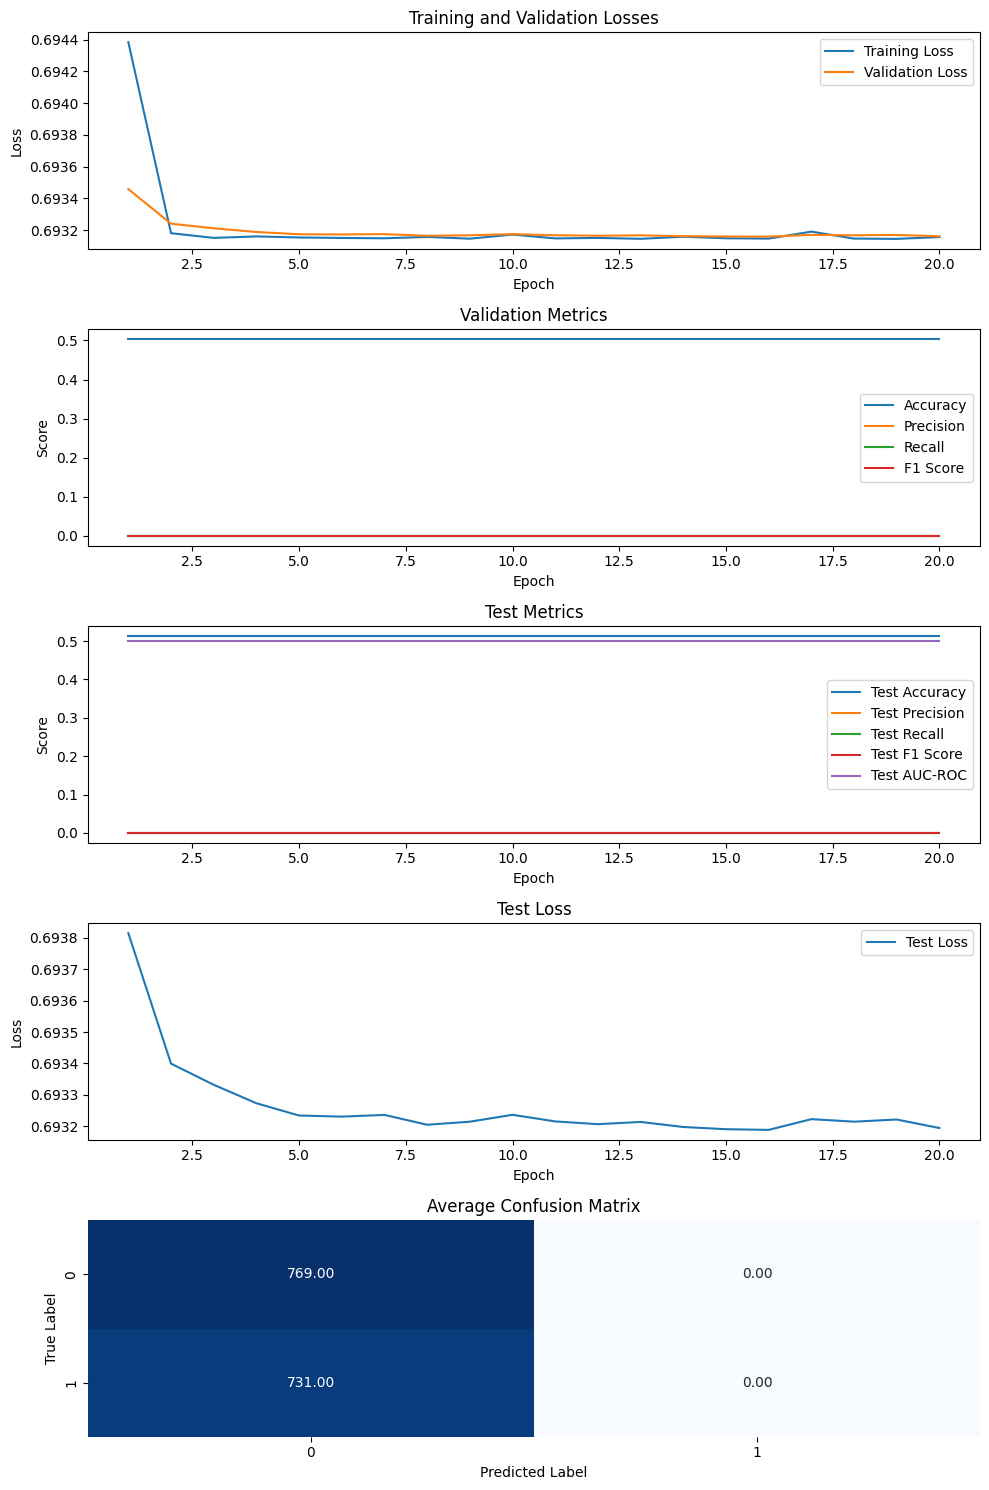

In [7]:
'''
RUN ONLY FOR TRAINING AND VALIDATION
'''

# Train the model on a minibatch for testing
from torch.optim import Adam
import torch
import gc
# Metrics library
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
import time 
import seaborn as sns

# Lists to store metrics for each epoch
train_losses = []
val_losses = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

test_losses = []
test_accuracies = []
test_precisions = []
test_recalls = []
test_f1_scores = []
test_auc_rocs = []
test_conf_matrices = []

test_loss = 0
test_accuracy = 0
test_precision = 0
test_recall = 0 
test_f1 = 0
test_roc_auc = 0


# Check if CUDA is available
cuda_available = torch.cuda.is_available()

if cuda_available:
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"CUDA is available. Number of GPUs: {num_gpus}")
    vit_model = vit_model.cuda()
else:
    print("CUDA is not available. Using CPU.")

# Validation loop
def validate(model, loss_func, val_loader):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for i, data in enumerate(val_loader, start = 0):
            inputs, target = data
            # Move input data to GPU if CUDA is available
            if cuda_available:
                inputs, target = inputs.cuda(), target.cuda()
                
            output = model(inputs)
            predictions = output # Predictions of x
            loss = loss_func(predictions.float(), target.float())
            total_loss += loss.item() 
            
            preds = (predictions > threshold).int() # Threshold is used to determine the predicted value - 0 or 1 based on threshold value
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # https://scikit-learn.org/stable/modules/model_evaluation.html
    avg_loss = total_loss / len(val_loader)
    accuracy = accuracy_score(
        all_targets, 
        all_preds
    )
    precision = precision_score(
        all_targets, 
        all_preds, 
        zero_division = 0,
        average = 'binary'
    )
    recall = recall_score(
        all_targets, 
        all_preds
    )
    f1 = f1_score(
        all_targets, 
        all_preds)

    return avg_loss, accuracy, precision, recall, f1

# Test loop
def test(model, loss_func, test_loader):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for i, data in enumerate(test_loader, start=0):
            inputs, target = data
            # Move input data to GPU if CUDA is available
            if cuda_available:
                inputs, target = inputs.cuda(), target.cuda()

            output = model(inputs) # Model
            predictions = output  # Predictions of x
            loss = loss_func(predictions.float(), target.float())
            total_loss += loss.item()

            preds = (predictions > threshold).int()  # Threshold is used to determine the predicted value - 0 or 1 based on the threshold value
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # Calculate AUC-ROC
    fpr, tpr, _ = roc_curve(all_targets, all_preds)
    roc_auc = auc(fpr, tpr)
    # Create confusion matrix
    conf_matrix = confusion_matrix(all_targets, all_preds)

    # https://scikit-learn.org/stable/modules/model_evaluation.html
    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(
        all_targets,
        all_preds
    )
    precision = precision_score(
        all_targets,
        all_preds,
        zero_division=0,
        average='binary'
    )
    recall = recall_score(
        all_targets,
        all_preds
    )
    f1 = f1_score(
        all_targets,
        all_preds
    )

    return avg_loss, accuracy, precision, recall, f1, roc_auc, conf_matrix

# Training loop - Calling validate and testing functions...
def train(
    model, 
    loss_func, 
    optimizer, 
    train_loader,
    val_loader, 
    test_loader,
    num_epochs = num_epochs,
):
    total_time_start = time.time()  # Record the start time
    
    for epoch in range(num_epochs):
        epoch_time_start = time.time()
        model.train()
        total_loss = 0.0
        # Iterate over dataset
        for i, data in enumerate(train_loader, start = 0):
            inputs, target = data # target shape: [BATCH_SIZE,1]
            
            # Move input data to GPU if CUDA is available
            if cuda_available:
                input_data, target = inputs.cuda(), target.cuda()
            
            optimizer.zero_grad() # Instanitate optimizer
            output = model(input_data)
            predictions = output # Predicition of x
            loss = loss_func(predictions.float(), target.float())
            loss.backward()
            # Gradient clipping to prevent exploding gradients
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient cannot surpass this value i.e. 1
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)

        # Validation call
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = validate(
            model = vit_model,
            loss_func = loss_func, 
            val_loader = val_loader
        )

        # Test call
        test_loss, test_accuracy, test_precision, test_recall, test_f1, test_roc_auc, test_conf_matrix = test(
            model = vit_model,
            loss_func = loss_func,
            test_loader = test_loader
        )

        # Append metrics to lists
        train_losses.append(avg_loss)
        val_losses.append(val_loss)
        accuracies.append(val_accuracy)
        precisions.append(val_precision)
        recalls.append(val_recall)
        f1_scores.append(val_f1)

        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        test_precisions.append(test_precision)
        test_recalls.append(test_recall)
        test_f1_scores.append(test_f1)
        test_auc_rocs.append(test_roc_auc)

        test_conf_matrices.append(test_conf_matrix)

        # Calculate and print the time taken for the epoch
        epoch_time_end = time.time()
        epoch_time_elapsed = epoch_time_end - epoch_time_start

        '''
        # Print training and validation metrics
        print(f'Epoch {epoch + 1}/{num_epochs} - '
              f'Training Loss: {avg_loss:.4f} - '
              f'Validation Loss: {val_loss:.4f} - '
              f'Validation Accuracy: {val_accuracy:.4f} - '
              f'Validation Precision: {val_precision:.4f} - '
              f'Validation Recall: {val_recall:.4f} - '
              f'Validation F1 Score: {val_f1:.4f}')
        '''
        # Testing prints
        print(f'Epoch {epoch + 1}/{num_epochs} - Time: {epoch_time_elapsed:.4f}s - '
              f'Training Loss: {avg_loss:.8f} - ' 
              f'Test Loss: {test_loss:.8f} - '
              f'Test Accuracy: {test_accuracy:.8f} - '
              f'Test Precision: {test_precision:.8f} - '
              f'Test Recall: {test_recall:.8f} - '
              f'Test F1 Score: {test_f1:.8f}')

        # Clear GPU memory after each epoch
        torch.cuda.empty_cache()
        gc.collect()

    # Calculate and print the total time taken
    total_time_end = time.time()
    total_time_elapsed = total_time_end - total_time_start
    print(f'Total Training Time: {total_time_elapsed:.4f}s')


    # Plotting
    epochs = np.arange(1, num_epochs + 1)
    plt.figure(figsize=(10, 15))  # Adjust the figure size accordingly
    
    # Plot Training and Validation Losses
    plt.subplot(5, 1, 1)  # Five rows, one column, first subplot
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy, Precision, Recall, and F1 Score for Validation
    plt.subplot(5, 1, 2)  # Five rows, one column, second subplot
    plt.plot(epochs, accuracies, label='Accuracy')
    plt.plot(epochs, precisions, label='Precision')
    plt.plot(epochs, recalls, label='Recall')
    plt.plot(epochs, f1_scores, label='F1 Score')
    plt.title('Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    # Plot Accuracy, Precision, Recall, F1 Score, and AUC-ROC for Test
    plt.subplot(5, 1, 3)  # Five rows, one column, third subplot
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.plot(epochs, test_precisions, label='Test Precision')
    plt.plot(epochs, test_recalls, label='Test Recall')
    plt.plot(epochs, test_f1_scores, label='Test F1 Score')
    plt.plot(epochs, test_auc_rocs, label='Test AUC-ROC')
    plt.title('Test Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    
    # Plot Testing Loss
    plt.subplot(5, 1, 4)  # Five rows, one column, fourth subplot
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.title('Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Confusion Matrices for each epoch
    plt.subplot(5, 1, 5)  # Five rows, one column, fifth subplot
    all_conf_matrices = np.stack(test_conf_matrices, axis=0)
    avg_conf_matrix = np.mean(all_conf_matrices, axis=0)  # Calculate the average confusion matrix
    sns.heatmap(avg_conf_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False)
    plt.title('Average Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    plt.tight_layout()
    plt.show()
    
# Training, validation and testing init
train(
    model = vit_model, 
    loss_func = loss_func, 
    optimizer = optimizer, 
    num_epochs = num_epochs,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader
)

In [8]:
# Shutdown the Ray server explicitly if needed

import ray 

ray.shutdown()

In [7]:
# Pytorch Ray Tune Hyperparameter tuning
# Previous cells need to be run first, except train/validation (above) cell
'''
https://docs.ray.io/en/latest/tune/examples/tune-pytorch-cifar.html#tune-pytorch-cifar-ref -> Inspiration source for using Ray Tune 
'''
import ray
from ray import tune, train
# from ray.train import Checkpoint
from ray.tune.schedulers import ASHAScheduler

def ray_tune(config: dict, train_loader = train_loader, val_loader = val_loader):
    
    vit_model_rayTune = VisionTransformer(
        n_layers = config['n_layers'],
        n_heads = config['n_heads'],
        dropout = config['dropout'], 
        activation = config['activation'],
        d_model = config['d_model'],
        dim_feedforward = config['dim_feedforward'],
        patch_emb = PatchEmbeddings( # Patch emb
            d_model = config['d_model'], 
            patch_size = config['patch_size'], 
            in_channels = 3
        ), 
        pos_emb = PositionalEmbedding( # Positional encoding
            d_model = config['d_model'],
            max_len = int(256 / config['patch_size']) ** 2 + 1
        ), 
        classification = ClassificationHead( # Classification head 
            d_model = config['d_model'], 
            n_hidden = config['n_hidden'], 
            n_classes = 1
        )
    )

    # Put model and data into ray object store
    model_id = ray.put(vit_model_rayTune)
    train_loader_id = ray.put(train_loader)
    val_loader_id = ray.put(val_loader)

    model = ray.get(model_id)
    train_loader = ray.get(train_loader_id)
    val_loader = ray.get(val_loader_id)
    

    # Loss function
    loss_func = nn.BCEWithLogitsLoss() # BCE=−1/n​∑i=1​(y_i​log(yHat_​i​)+(1−y_i​)log(1−yHat_i​))
    
    # Optimizer 
    optimizer = Adam(
        vit_model_rayTune.parameters(), 
        lr = config['lr'],
        weight_decay = config['weight_decay']
    )
    
    device = "cpu"
    if torch.cuda.is_available(): 
        device = "cuda:0"

    model = ray.get(model_id)
    model = model.to(device)
    train_loader = ray.get(train_loader_id)
    val_loader = ray.get(val_loader_id)

    criterion = nn.CrossEntropyLoss() 
    optimizer = Adam(
        model.parameters(), 
        lr = config['lr'],
        weight_decay = config['weight_decay']
    )

    # TODO: Get checkpoint? Check docs.
    train_loader = DataLoader(
        train_set, 
        batch_size = config['batch_size'], 
        shuffle=True
    ) # Shuffle the training set
    val_loader = DataLoader(
        val_set, 
        batch_size = config['batch_size'], 
        shuffle=False
    )

    nEpochs = config['nEpochs']
    for epoch in range(nEpochs):
        running_loss = 0.0
        epoch_steps = 0
        # Training 
        for i, data, in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) 

            labels = labels.float()
            
            optimizer.zero_grad()
            outputs = model(inputs).float()
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_steps += 1 

        # Validation 
        val_loss = 0.0
        val_steps = 0
        total = 0 
        correct = 0 
        for i, data in enumerate(val_loader, 0):
            with torch.no_grad(): # No backprop
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                labels = labels.float()

                outputs = model(inputs).float() 
                predicted = torch.sigmoid(outputs) > config["threshold"]
                total += labels.size(0)
                correct += (predicted == labels).sum().item() 
                loss = loss_func(outputs, labels.float())
                val_loss += loss.cpu().numpy() 
                val_steps += 1 

        test_loss = 0.0
        test_steps = 0
        test_total = 0 
        test_correct = 0 
        for i, data in enumerate(test_loader, 0):
            with torch.no_grad(): # No backprop
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                labels = labels.float()

                outputs = model(inputs).float() 
                predicted = torch.sigmoid(outputs) > config["threshold"]
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item() 
                loss = loss_func(outputs, labels.float())
                test_loss += loss.cpu().numpy() 
                test_steps += 1

        train.report({"accuracy": test_correct / test_total})


def setup_ray_tune_and_run():
    # Configs - Hyperparameters + model parameters 
    config = {
        "lr": tune.loguniform(1e-4, 1e-1), # [0.0001, 0.1]
        "batch_size": tune.randint(4, 8), # 8, 16 ,32, 64 <- Try these on a bigger system
        "weight_decay": tune.loguniform(1e-3, 1), # [0.001, 1.0]
        "nEpochs": tune.grid_search([10, 20]),
        "d_model": tune.grid_search([256, 512]),
        "n_heads": tune.grid_search([1, 2, 4]),
        "dim_feedforward": tune.grid_search([256, 512]),
        "dropout": tune.uniform(0.1, 0.5),
        "n_layers": tune.grid_search([1, 2, 4]),
        "patch_size": tune.grid_search([8, 16]),
        "n_hidden": tune.grid_search([1, 2, 4]),
        "activation": tune.grid_search(["gelu", "relu"]),
        "threshold": tune.uniform(0.1, 0.9)
    }

    # max_num_epochs = 
    scheduler = ASHAScheduler(
            # max_t = max_num_epochs,
            grace_period = 1,
            reduction_factor = 2
    )
    
    resources = {
        "cpu": 3,  # Number of CPU cores per trial
        "gpu": 0.5,  # Fraction of a GPU per trial (0.5 means half a GPU)
    }
    
    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(ray_tune),
            resources = resources
        ),
        tune_config = tune.TuneConfig(
            metric = "accuracy",
            mode = "max",
            scheduler = scheduler,
            # Num samples? 
        ),
        param_space = config,
    )
    results = tuner.fit() 
    best_result = results.get_best_result("accuracy", "max")

    print(f'Best trial config: {best_result.config}')
    

# Start 
setup_ray_tune_and_run() 

(raylet) Warning: The actor ImplicitFunc is very large (75 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
(ray_tune pid=18371) Max_len: 1025
(ray_tune pid=18370) Max_len: 1025 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(ray_tune pid=18370) Max_len: 1025 [repeated 2x across cluster]
(ray_tune pid=18370) Max_len: 1025 [repeated 2x across cluster]
(ray_tune pid=18370) Max_len: 1025 [repeated 2x across cluster]
(ray_tune pid=18371) Max_len: 1025 [repeated 2x across cluster]
(ray_tune pid=18370) Max_len: 1025 [repeated 2x across cluster]
(ray_tune pid=18370) Max_len: 1025 [repeated 2x across cluster]
(ray_tune pid=18371) Max_len: 1025
(ray_tune pid=18370) Max_len: 1025
(ray_tune pid=18370) Max_len

2023-12-29 16:42:31,859	WARNING tune.py:186 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2023-12-29 16:42:32,262	INFO tune.py:1042 -- Total run time: 651.74 seconds (651.10 seconds for the tuning loop).
2023-12-29 16:42:32,263	WARNING tune.py:1057 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="/home/magnusjsc/ray_results/ray_tune_2023-12-29_16-31-37", trainable=...)
2023-12-29 16:42:32,322	WARNING experiment_analysis.py:193 -- Failed to fetch metrics for 16 trial(s):
- ray_tune_5cecd_00051: FileNotFoundError('Could not fetch metrics for ray_tune_5cecd_00051: both result.json and progress.csv were not found at /home/magnusjsc/ray_results/ray_tune_2023-12-29_16-31-37/ray_tune_5cecd_00051_51_activation=relu,batch_size=5,d_model=512,dim_feedforward=256,dropout=0.4073,lr=0.0733,

Best trial config: {'lr': 0.01987734587686648, 'batch_size': 4, 'weight_decay': 0.004061491880725164, 'nEpochs': 10, 'd_model': 512, 'n_heads': 1, 'dim_feedforward': 256, 'dropout': 0.34783161731715817, 'n_layers': 1, 'patch_size': 8, 'n_hidden': 1, 'activation': 'relu', 'threshold': 0.7038984058218188}
